# Customer Segmentation Using RFM Analysis

---

**Objective**: Perform RFM (Recency, Frequency, Monetary) analysis to segment customers based on their purchasing behavior.

**Dataset**: Online Retail Dataset (UCI ML Repository)

---



In [26]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
%matplotlib inline

In [27]:
# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [28]:
# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
retail = pd.read_excel(url)

## 1. Data Preprocessing

## Data cleaning

In [29]:
# Remove rows with negative quantities or prices
retail = retail[(retail['Quantity'] > 0) & (retail['UnitPrice'] > 0)]

In [30]:
# Check dataset info
retail.info()

<class 'pandas.core.frame.DataFrame'>
Index: 530104 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    530104 non-null  object        
 1   StockCode    530104 non-null  object        
 2   Description  530104 non-null  object        
 3   Quantity     530104 non-null  int64         
 4   InvoiceDate  530104 non-null  datetime64[ns]
 5   UnitPrice    530104 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      530104 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 36.4+ MB


In [31]:
# Remove rows with missing CustomerID
retail = retail[retail['CustomerID'].notna()]

In [32]:
# Convert CustomerID to integer
retail['CustomerID'] = retail['CustomerID'].astype(int)

In [33]:
# Create TotalPrice column
retail['TotalPrice'] = retail['Quantity'] * retail['UnitPrice']

In [34]:
# Drop duplicates
retail = retail.drop_duplicates()

In [35]:
# Check cleaned data
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


## 2. RFM Analysis

In [36]:
# Set analysis date (1 day after last invoice)
analysis_date = retail['InvoiceDate'].max() + timedelta(days=1)

In [37]:
# Calculate RFM metrics
rfm = retail.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).reset_index()

In [38]:
# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [39]:
# Calculate RFM scores, Frequency and Monetary scores
rfm['RecencyScore'] = pd.cut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1], duplicates='drop')
rfm['FrequencyScore'] = pd.cut(rfm['Frequency'], bins=5, labels=[1, 2, 3, 4, 5], duplicates='drop')
rfm['MonetaryScore'] = pd.cut(rfm['Monetary'], bins=5, labels=[1, 2, 3, 4, 5], duplicates='drop')

In [40]:
# Combine scores
rfm['RFM_Score'] = rfm['RecencyScore'].astype(str) + rfm['FrequencyScore'].astype(str) + rfm['MonetaryScore'].astype(str)


## 3. Customer Segmentation

In [41]:
# Define segments
segment_map = {
    r'[4-5][4-5][4-5]': 'Champions',
    r'[3-5][3-5][3-5]': 'Loyal Customers',
    r'[3-5][1-3][1-3]': 'Potential Loyalists',
    r'[4-5][1-2][1-2]': 'New Customers',
    r'[3-4][1-2][1-2]': 'Promising',
    r'[2-3][3-4][3-4]': 'Need Attention',
    r'[1-2][3-5][3-5]': 'At Risk',
    r'[1-2][1-2][1-2]': 'Hibernating',
    r'[1-2][1-2][3-5]': "Can't Lose Them"
}

In [42]:
rfm['Segment'] = rfm['RFM_Score'].replace(segment_map, regex=True)

# Assign a default segment for unmapped RFM scores
rfm['Segment'] = rfm['Segment'].apply(lambda x: x if x in segment_map.values() else 'Others')

In [43]:
# Count customers in each segment
segment_counts = rfm['Segment'].value_counts().sort_values(ascending=False)

/tmp/ipython-input-2998604943.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_counts.values, y=segment_counts.index, palette='viridis')


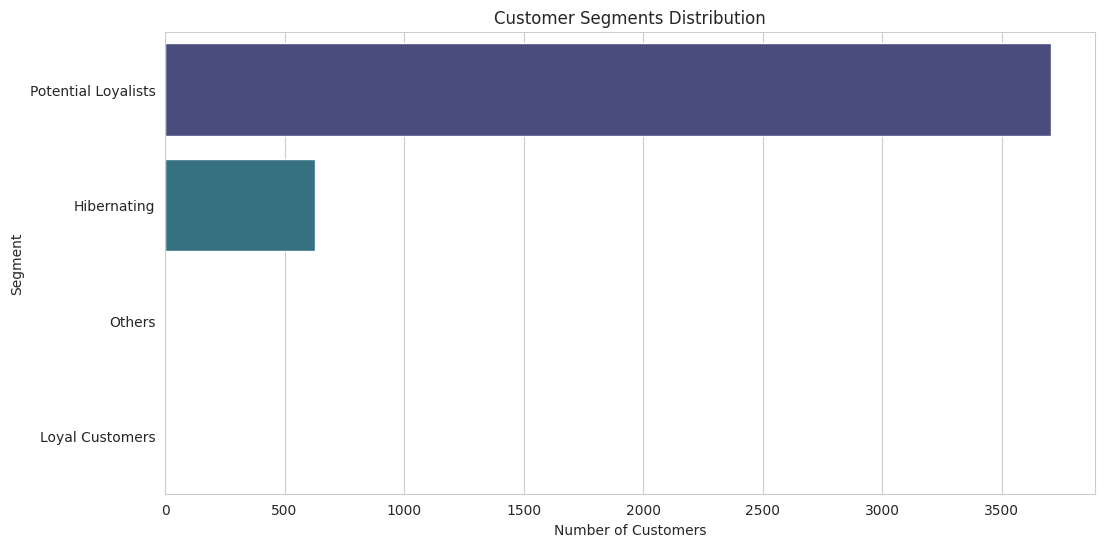

In [44]:
plt.figure(figsize=(12, 6))
sns.barplot(x=segment_counts.values, y=segment_counts.index, palette='viridis')
plt.title('Customer Segments Distribution')
plt.xlabel('Number of Customers')
plt.ylabel('Segment')
plt.show()

## 4. Segment Analysis (Bonus)

In [45]:
# Calculate average RFM values per segment
segment_analysis = rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Count'})

In [46]:
segment_analysis

,Recency,Frequency,Monetary,Count
Segment,,,,
Hibernating,294.431310,1.354633,605.716166,626
Loyal Customers,1.000000,201.000000,143711.170000,1
Others,2.600000,78.000000,187155.960000,5
Potential Loyalists,58.579331,4.612250,2004.462926,3706


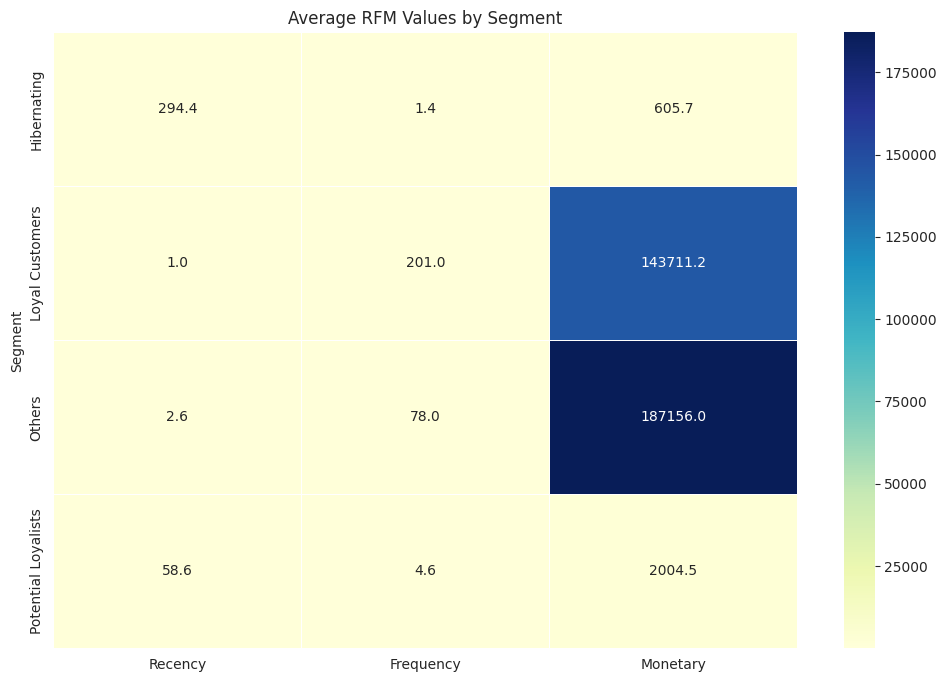

In [47]:
# Heatmap of segment characteristics
plt.figure(figsize=(12, 8))
sns.heatmap(segment_analysis[['Recency', 'Frequency', 'Monetary']],
            annot=True, fmt='.1f', cmap='YlGnBu', linewidths=0.5)
plt.title('Average RFM Values by Segment')
plt.show()

## Marketing Recommendations:
 1. **Champions**: Reward these customers with exclusive offers
 2. **Loyal Customers**: Implement a loyalty program to maintain engagement
 3. **Potential Loyalists**: Target with personalized recommendations
 4. **New Customers**: Send welcome series and onboarding content
 5. **At Risk**: Win-back campaigns with special incentives
 6. **Hibernating**: Reactivation campaigns with strong offers